# Lesson 40: Distributed representations demonstration

This notebook demonstrates using pre-trained word embeddings and extending them to document-level representations.

**1. Pre-trained word embeddings**
- 1.1. Loading pre-trained Word2Vec
- 1.2. Word similarity and analogies

**2. Document embeddings**
- 2.1. Averaging word vectors
- 2.2. Doc2Vec

**3. Document similarity comparison**


## Notebook set up

**Note**: depending on your environment, you may need to install NLTK and gensim:

```text
pip install nltk gensim
```

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize

import gensim.downloader as api
import nltk
nltk.download('punkt', quiet=True)

True

### Sample documents

In [2]:
# Sample documents for demonstration
documents = [
    'The king ruled his kingdom with wisdom and justice',
    'The queen governed her realm with grace and power',
    'Machine learning algorithms can learn patterns from data',
    'Deep neural networks are powerful for pattern recognition',
    'The cat sat lazily on the warm sunny windowsill',
    'Dogs love playing fetch in the park with their owners'
]

# Tokenize documents
tokenized_docs = [word_tokenize(doc.lower()) for doc in documents]

print('Sample documents:')
for i, doc in enumerate(documents):
    print(f'  Doc {i+1}: {doc}')

Sample documents:
  Doc 1: The king ruled his kingdom with wisdom and justice
  Doc 2: The queen governed her realm with grace and power
  Doc 3: Machine learning algorithms can learn patterns from data
  Doc 4: Deep neural networks are powerful for pattern recognition
  Doc 5: The cat sat lazily on the warm sunny windowsill
  Doc 6: Dogs love playing fetch in the park with their owners


## 1. Pre-trained word embeddings

### 1.1. Loading pre-trained Word2Vec

Pre-trained embeddings capture semantic relationships learned from large text corpora.

Gensim [downloader](https://radimrehurek.com/gensim/downloader.html) documentation

In [3]:
# Load pre-trained GloVe embeddings (smaller than Google News for demo)
# Using glove-wiki-gigaword-100 (100-dimensional vectors)
w2v_model = api.load('glove-wiki-gigaword-100')

print(f'Vocabulary size: {len(w2v_model)}')
print(f'Vector dimensions: {w2v_model.vector_size}')

Vocabulary size: 400000
Vector dimensions: 100


### 1.2. Word similarity and analogies

In [4]:
# Find similar words
print('Words most similar to "king":')
for word, score in w2v_model.most_similar('king', topn=5):
    print(f'  {word}: {score:.3f}')

print('\nWords most similar to "computer":')
for word, score in w2v_model.most_similar('computer', topn=5):
    print(f'  {word}: {score:.3f}')

Words most similar to "king":
  prince: 0.768
  queen: 0.751
  son: 0.702
  brother: 0.699
  monarch: 0.698

Words most similar to "computer":
  computers: 0.875
  software: 0.837
  technology: 0.764
  pc: 0.737
  hardware: 0.729


In [5]:
# Word analogies: king - man + woman = ?
print('Analogy: king - man + woman = ?')
result = w2v_model.most_similar(positive=['king', 'woman'], negative=['man'], topn=3)

for word, score in result:
    print(f'  {word}: {score:.3f}')

print('\nAnalogy: actor - man + woman = ?')
result = w2v_model.most_similar(positive=['actor', 'woman'], negative=['man'], topn=3)

for word, score in result:
    print(f'  {word}: {score:.3f}')

print('\nAnalogy: paris - france + germany = ?')
result = w2v_model.most_similar(positive=['paris', 'germany'], negative=['france'], topn=3)

for word, score in result:
    print(f'  {word}: {score:.3f}')

Analogy: king - man + woman = ?
  queen: 0.770
  monarch: 0.684
  throne: 0.676

Analogy: actor - man + woman = ?
  actress: 0.907
  comedian: 0.689
  actresses: 0.683

Analogy: paris - france + germany = ?
  berlin: 0.885
  frankfurt: 0.799
  vienna: 0.768


**Understanding these classic analogies:**

These demonstrate that word embeddings capture semantic relationships through vector arithmetic:

1. **king - man + woman ≈ queen**
   - This shows the model understands gender relationships in royalty
   - The vector difference (king - man) captures "royalty without gender"
   - Adding woman gives "female royalty" = queen

2. **Actor - man + woman ≈ actress**
   - This shows the model understands gender relationships in performers
   - The vector difference (actor - man) captures "performer without gender"
   - Adding woman gives "female performer" = actress
   
2. **paris - france + germany ≈ berlin**
   - This shows the model understands country-capital relationships
   - The vector difference (paris - france) captures "capital city of"
   - Adding germany gives "capital of Germany" = berlin

These algebraic properties emerge naturally from training on large text corpora, where words appearing in similar contexts develop similar vector representations.

### 1.3. Analogies in 2D space

In [6]:
# Select interesting words representing different semantic categories
interesting_words = [
    'man', 'woman', 'king', 'queen', 'actor', 'actress'
]

# Get Word2Vec embeddings
w2v_vectors = np.array([w2v_model[w] for w in interesting_words])

# Compute the gender direction by averaging difference vectors
gender_vector = (
    (w2v_model['woman'] - w2v_model['man']) +
    (w2v_model['queen'] - w2v_model['king']) +
    (w2v_model['actress'] - w2v_model['actor'])
) / 3

# Normalize the gender vector
gender_vector = gender_vector / np.linalg.norm(gender_vector)

# Project each word onto the gender direction
gender_projections = w2v_vectors @ gender_vector

# Create an orthogonal direction (using PCA on residuals)
residuals = w2v_vectors - np.outer(gender_projections, gender_vector)

pca = PCA(n_components=1)
orthogonal_projections = pca.fit_transform(residuals).flatten()

# Combine into 2D coordinates
w2v_2d = np.column_stack([gender_projections, orthogonal_projections])

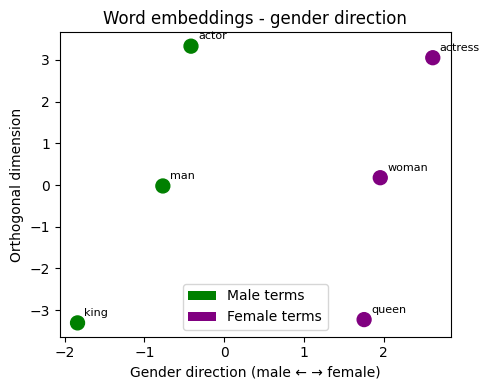

In [7]:
# Create color mapping by word category
colors = []

for word in interesting_words:
    if word in ['man', 'king', 'actor']:
        colors.append('green')

    elif word in ['woman', 'queen', 'actress']:
        colors.append('purple')

# Create 1x1 subplot
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Word2Vec
ax.scatter(w2v_2d[:, 0], w2v_2d[:, 1], c=colors, s=100)

for i, word in enumerate(interesting_words):
    ax.annotate(
        word, (w2v_2d[i, 0], w2v_2d[i, 1]), 
        xytext=(5, 5), textcoords='offset points', fontsize=8
)
    
ax.set_title('Word embeddings - gender direction')
ax.set_xlabel('Gender direction (male ← → female)')
ax.set_ylabel('Orthogonal dimension')

# Add legend
legend_elements = [
    Patch(facecolor='green', label='Male terms'),
    Patch(facecolor='purple', label='Female terms')
]

ax.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

## 2. Document embeddings

### 2.1. Averaging word vectors

A simple approach to create document embeddings is to average the word vectors of all words in the document.

In [8]:
# Create document vector by averaging word vectors
def get_doc_vector_avg(tokens, model):

    vectors = []
    for token in tokens:
        if token in model:
            vectors.append(model[token])

    if vectors:
        return np.mean(vectors, axis=0)
    return np.zeros(model.vector_size)

# Create document vectors
doc_vectors_avg = np.array([get_doc_vector_avg(doc, w2v_model) for doc in tokenized_docs])

print(f'Document vectors shape: {doc_vectors_avg.shape}')

Document vectors shape: (6, 100)


### 2.2. Doc2Vec

Doc2Vec learns document embeddings directly, treating each document as a unique entity during training.

Gensim [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html) documentation

In [9]:
# Prepare tagged documents for Doc2Vec
tagged_docs = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(tokenized_docs)]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(
    documents=tagged_docs,
    vector_size=100,
    window=2,
    min_count=1,
    epochs=100,
    seed=315
)

# Get document vectors
doc_vectors_d2v = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])

print(f'Doc2Vec vectors shape: {doc_vectors_d2v.shape}')

Doc2Vec vectors shape: (6, 100)


## 3. Document similarity comparison

Compare how averaging and Doc2Vec capture document similarity.

In [10]:
# Compute cosine similarity matrices
sim_matrix_avg = cosine_similarity(doc_vectors_avg)
sim_matrix_d2v = cosine_similarity(doc_vectors_d2v)

# Create dataframes with document labels
doc_labels = [f'Doc {i+1}' for i in range(len(documents))]

sim_avg_df = pd.DataFrame(sim_matrix_avg.round(3), index=doc_labels, columns=doc_labels)
sim_d2v_df = pd.DataFrame(sim_matrix_d2v.round(3), index=doc_labels, columns=doc_labels)

print('Document similarity (Averaging method):')
sim_avg_df

Document similarity (Averaging method):


,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6
Doc 1,1.000,0.933,0.632,0.754,0.701,0.832
Doc 2,0.933,1.000,0.670,0.774,0.747,0.867
Doc 3,0.632,0.670,1.000,0.844,0.580,0.731
Doc 4,0.754,0.774,0.844,1.000,0.630,0.772
Doc 5,0.701,0.747,0.580,0.630,1.000,0.820
Doc 6,0.832,0.867,0.731,0.772,0.820,1.000


In [11]:
print('Document similarity (Doc2Vec method):')
sim_d2v_df

Document similarity (Doc2Vec method):


,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6
Doc 1,1.000,0.290,0.356,0.252,0.274,0.286
Doc 2,0.290,1.000,0.364,0.250,0.360,0.287
Doc 3,0.356,0.364,1.000,0.433,0.324,0.336
Doc 4,0.252,0.250,0.433,1.000,0.339,0.362
Doc 5,0.274,0.360,0.324,0.339,1.000,0.249
Doc 6,0.286,0.287,0.336,0.362,0.249,1.000


In [12]:
# Find most similar document pairs
print('Expected similar pairs:')
print('  - Doc 1 & Doc 2 (both about royalty/governance)')
print('  - Doc 3 & Doc 4 (both about machine learning)')
print('  - Doc 5 & Doc 6 (both about pets/animals)')

print('\nActual most similar pairs (averaging):')
print(f'  Doc 1 most similar to: Doc {np.argsort(sim_matrix_avg[0])[-2] + 1}')
print(f'  Doc 3 most similar to: Doc {np.argsort(sim_matrix_avg[2])[-2] + 1}')
print(f'  Doc 5 most similar to: Doc {np.argsort(sim_matrix_avg[4])[-2] + 1}')

Expected similar pairs:
  - Doc 1 & Doc 2 (both about royalty/governance)
  - Doc 3 & Doc 4 (both about machine learning)
  - Doc 5 & Doc 6 (both about pets/animals)

Actual most similar pairs (averaging):
  Doc 1 most similar to: Doc 2
  Doc 3 most similar to: Doc 4
  Doc 5 most similar to: Doc 6
